In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from lifelines import KaplanMeierFitter, CoxPHFitter

# Load the data
df = pd.read_csv("Prompt1AccountLevel.csv")
df.columns = df.columns.str.strip()

# Clean numeric columns
df['GamesAttended'] = pd.to_numeric(df['GamesAttended'], errors='coerce')
df['AvgSpend'] = pd.to_numeric(df['AvgSpend'].replace('[\$,]', '', regex=True), errors='coerce')
df['DistanceToArena'] = pd.to_numeric(df['DistanceToArena'], errors='coerce')
df['BasketballPropensity'] = pd.to_numeric(df['BasketballPropensity'], errors='coerce')
df.dropna(subset=['GamesAttended'], inplace=True)

df.head()


,Season,AccountNumber,SingleGameTickets,PartialPlanTickets,GroupTickets,STM,AvgSpend,GamesAttended,FanSegment,DistanceToArena,BasketballPropensity,SocialMediaEngagement
0,2023,1,0,0,0,0,467.0,0,F,12.0,872.0,Low
1,2023,2,2,0,0,0,116.0,1,A,47.0,485.0,Low
2,2023,3,3,0,0,0,107.0,1,B,6.0,896.0,Low
3,2023,4,0,0,3,0,27.0,1,C,3.0,467.0,High
4,2023,5,0,0,2,0,14.0,1,A,4.0,582.0,Medium


In [3]:
median_games = df['GamesAttended'].median()

# Define event: 1 if the fan attended fewer games than the median (early churn), else 0.
df['event'] = (df['GamesAttended'] < median_games).astype(int)
df['duration'] = df['GamesAttended']

df[['GamesAttended', 'duration', 'event']].head()


,GamesAttended,duration,event
0,0,0,1
1,1,1,0
2,1,1,0
3,1,1,0
4,1,1,0


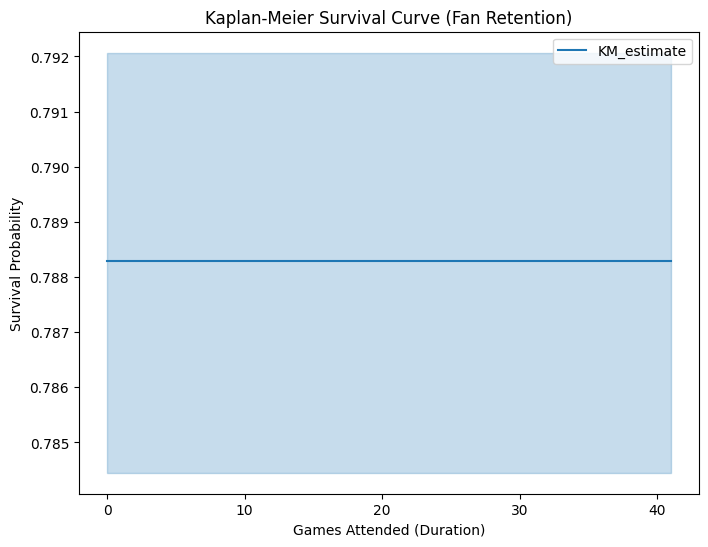

In [4]:
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier model
kmf.fit(durations=df['duration'], event_observed=df['event'])

# Plot the survival function
plt.figure(figsize=(8,6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve (Fan Retention)')
plt.xlabel('Games Attended (Duration)')
plt.ylabel('Survival Probability')
plt.show()


<lifelines.CoxPHFitter: fitted with 36796 total observations, 29320 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 36796
number of events observed = 7476
   partial log-likelihood = -77683.62
         time fit was run = 2025-02-09 01:23:46 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
AvgSpend              0.00      1.00      0.00            0.00            0.00                1.00                1.00
DistanceToArena       0.00      1.00      0.00            0.00            0.00                1.00                1.00
BasketballPropensity -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
STM                  -0.06      0.94      0.05           -0.16            0.05                0.85                1.05

                      cmp to     z      p  -log2(p)
covariate                                          
AvgSpend                0.00 11.88 <0.005    105.79
DistanceToArena         0.00  3.85 <0.005     13.08
BasketballPropensity    0.00 -9.38 <0.005     67.01
STM                     0.00 -1.09   0.27      1.86
---
Concordance = 0.55
Partial AIC = 155375.23
log-likelihood ratio test = 191.81 on 4 df
-log2(p) of ll-ratio test = 131.76

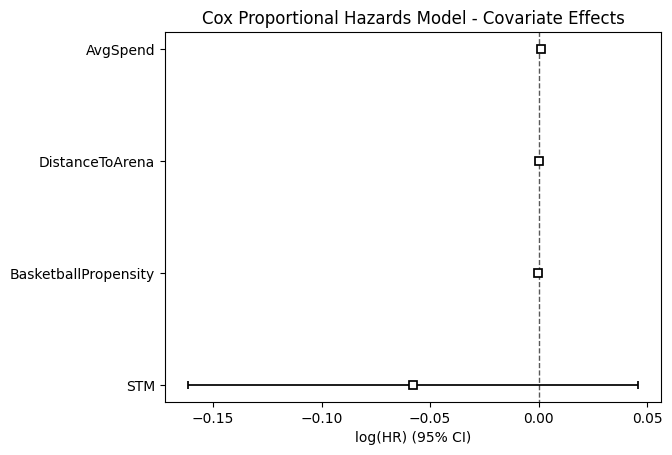

In [5]:
# Choose covariates for the Cox model (for example: AvgSpend, DistanceToArena, BasketballPropensity, STM)
covariates = ['AvgSpend', 'DistanceToArena', 'BasketballPropensity', 'STM']
df_cox = df[['duration', 'event'] + covariates].dropna()

cph = CoxPHFitter()
cph.fit(df_cox, duration_col='duration', event_col='event')
cph.print_summary()  # Model summary

# Plot the hazard ratios
cph.plot()
plt.title("Cox Proportional Hazards Model - Covariate Effects")
plt.show()


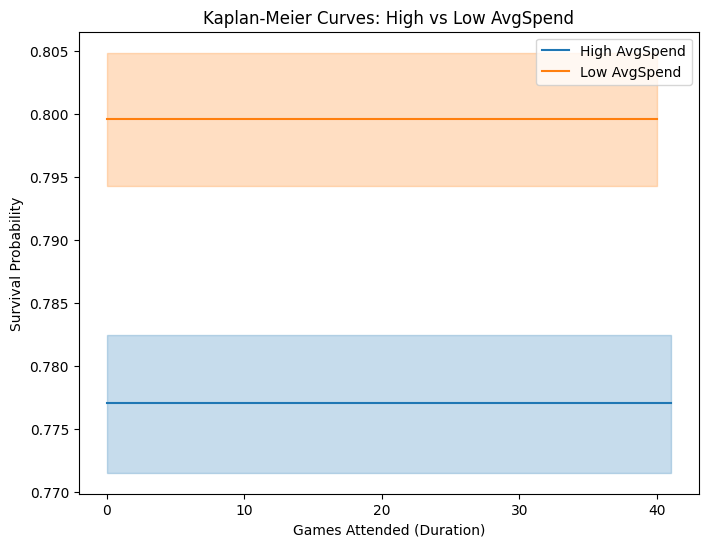

In [6]:
median_spend = df['AvgSpend'].median()
df['HighSpend'] = (df['AvgSpend'] >= median_spend).astype(int)

kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()

group_high = df[df['HighSpend'] == 1]
group_low = df[df['HighSpend'] == 0]

plt.figure(figsize=(8,6))
kmf_high.fit(durations=group_high['duration'], event_observed=group_high['event'], label="High AvgSpend")
kmf_low.fit(durations=group_low['duration'], event_observed=group_low['event'], label="Low AvgSpend")
ax = kmf_high.plot_survival_function()
kmf_low.plot_survival_function(ax=ax)
plt.title("Kaplan-Meier Curves: High vs Low AvgSpend")
plt.xlabel("Games Attended (Duration)")
plt.ylabel("Survival Probability")
plt.show()
